In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import os
import math
import librosa

DATASET_PATH = "/content/drive/MyDrive/Gtaz/Data/genres_original"
JSON_PATH = "/content/drive/MyDrive/Gtaz/data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    # mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc)
                    mfcc=librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=40)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
        
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

Streaming output truncated to the last 5000 lines.

Processing: jazz
/content/drive/MyDrive/Gtaz/Data/genres_original/jazz/jazz.00000.wav, segment:1
/content/drive/MyDrive/Gtaz/Data/genres_original/jazz/jazz.00000.wav, segment:2
/content/drive/MyDrive/Gtaz/Data/genres_original/jazz/jazz.00000.wav, segment:3
/content/drive/MyDrive/Gtaz/Data/genres_original/jazz/jazz.00000.wav, segment:4
/content/drive/MyDrive/Gtaz/Data/genres_original/jazz/jazz.00000.wav, segment:5
/content/drive/MyDrive/Gtaz/Data/genres_original/jazz/jazz.00000.wav, segment:6
/content/drive/MyDrive/Gtaz/Data/genres_original/jazz/jazz.00000.wav, segment:7
/content/drive/MyDrive/Gtaz/Data/genres_original/jazz/jazz.00000.wav, segment:8
/content/drive/MyDrive/Gtaz/Data/genres_original/jazz/jazz.00000.wav, segment:9
/content/drive/MyDrive/Gtaz/Data/genres_original/jazz/jazz.00000.wav, segment:10
/content/drive/MyDrive/Gtaz/Data/genres_original/jazz/jazz.00004.wav, segment:1
/content/drive/MyDrive/Gtaz/Data/genres_original/j

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 130, 64)           26880     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 64,714
Trainable params: 64,714
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
188/188 [==============================] -

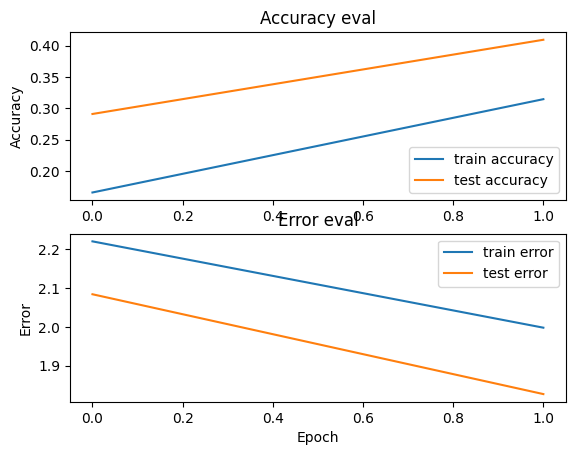

79/79 - 3s - loss: 1.8553 - accuracy: 0.3757 - 3s/epoch - 41ms/step

Test accuracy: 0.3756507933139801


In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "/content/drive/MyDrive/Gtaz/data_10.json"


def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates RNN-LSTM model
    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=2)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

In [ ]:
model.save('my_model.h5')

In [ ]:
import tensorflow as tf

In [ ]:
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 130, 64)           26880     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 64,714
Trainable params: 64,714
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

ValueError: ignored

In [ ]:
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import librosa
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

In [ ]:
filename="/content/drive/MyDrive/Gtaz/Data/genres_original/blues/blues.00000.wav"
audio, sample_rate = librosa.load(filename) 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)


#librosa.display.waveshow(data,sr=sample_rate)
# display(Audio(filename, autoplay=True))

#print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
# print(mfccs_scaled_features)
# print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features[1],mfccs_scaled_features[2])
classes_x=np.argmax(predicted_label,axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(classes_x) 
print(prediction_class)

IndexError: ignored

In [ ]:
num_segments=5
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import keras
from keras.models import load_model
import numpy as np

import librosa

audio_file = '/content/drive/MyDrive/Gtaz/Data/genres_original/hiphop/hiphop.00001.wav'
# start = samples_per_segment * 1
# finish = start + samples_per_segment

                    # extract mfcc
                    # mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc)

audio_file, sr = librosa.load(audio_file)



                # process all segments of audio file


                    # calculate start and finish sample for current segment
                   

                    # extract mfcc
                    # mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc)
mfcc=librosa.feature.mfcc(y=audio_file, sr=sample_rate, n_mfcc=40)
mfcc = mfcc.T
# start = samples_per_segment * 1
# finish = start + samples_per_segment

                    # extract mfcc


# data_processed = librosa.feature.mfcc(y=audio_file, sr=sr, n_mfcc=40)

data_processed =mfcc




data_processed = np.expand_dims(data_processed, axis=0)
data_padded = pad_sequences(data_processed, maxlen=130, padding='post', truncating='post')
prediction = model.predict(data_padded)
predicted_class = np.argmax(prediction)

1/1 [==============================] - 0s 47ms/step


In [ ]:

print(predicted_class)

6
